In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.decomposition import PCA
#from sklearn.preprocessing import Imputer
from sklearn.utils import resample
import surprise
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import r2_score
# Import ensemble machine learning library
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor)
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
# Import Linear Regression machine learning library
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix

scaler = StandardScaler()
import seaborn
import warnings
warnings.filterwarnings('ignore')
import itertools

In [4]:

#Read the dataset and assigning new column name to the 

rating_data=pd.read_csv('ratings_Electronics.csv',names=['userId', 'productId','Rating','timestamp'])


In [5]:
df1 = rating_data.copy()

In [6]:
rating_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,132793040,5,1365811200
1,A2CX7LUOHB2NDG,321732944,5,1341100800
2,A2NWSAGRHCP8N5,439886341,1,1367193600
3,A2WNBOD3WNDNKT,439886341,3,1374451200
4,A1GI0U4ZRJA8WN,439886341,1,1334707200


In [7]:
rating_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 4 columns):
userId       1048576 non-null object
productId    1048576 non-null object
Rating       1048576 non-null int64
timestamp    1048576 non-null int64
dtypes: int64(2), object(2)
memory usage: 32.0+ MB


In [8]:
rating_data.shape

(1048576, 4)

In [9]:
rating_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 4 columns):
userId       1048576 non-null object
productId    1048576 non-null object
Rating       1048576 non-null int64
timestamp    1048576 non-null int64
dtypes: int64(2), object(2)
memory usage: 32.0+ MB


In [10]:
rating_data.apply(lambda x: len(x.unique()))

userId       786330
productId     61894
Rating            5
timestamp      5489
dtype: int64

In [11]:
print("The Distinct Rating Values are: ",rating_data.Rating.unique())

The Distinct Rating Values are:  [5 1 3 2 4]


In [12]:
print('Number of missing values across columns-\n', rating_data.isnull().sum())

Number of missing values across columns-
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


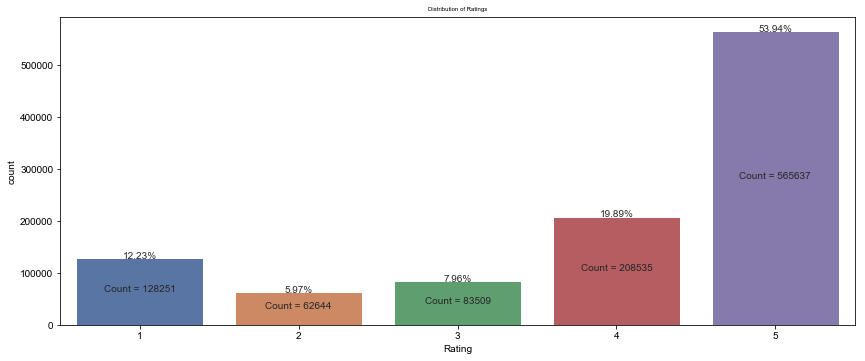

In [13]:

f,ax=plt.subplots(figsize=(12,5))
sns.set(font_scale=0.5)
ax = sns.countplot(x = "Rating", data=rating_data)
my_text  = ax.set_title("Distribution of Ratings")
total = len(rating_data) # for calculation of percentage

for p in ax.patches:
    #get Height of the column
    height = p.get_height()
    X = p.get_x() + p.get_width()/2
    Y = height + 4
    my_text  = ax.text(X, Y, '{:1.2f}%'.format((height/total)*100), ha="center", size=10)
    my_text  = ax.text(X, Y/2, f'Count = {height}', ha="center", size=10)
    plt.tight_layout()


In [14]:

#Analysis of rating given by the user 

no_of_rated_products_per_user = rating_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

In [15]:
no_of_rated_products_per_user.describe()

count    786330.000000
mean          1.333506
std           1.385612
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: Rating, dtype: float64

In [16]:

quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

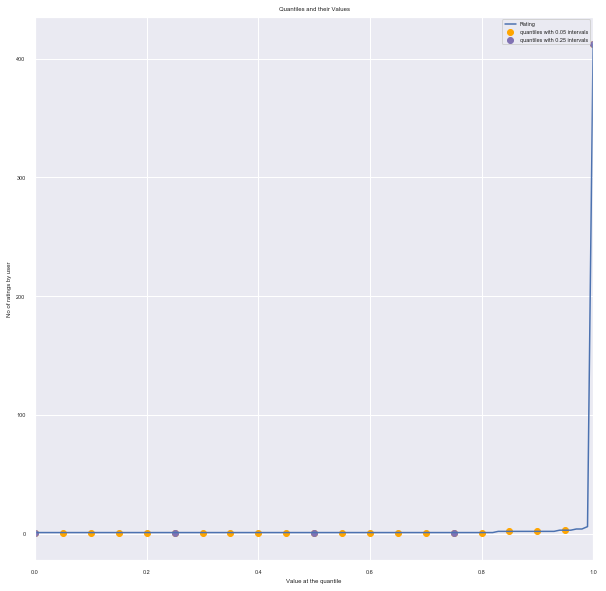

In [17]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [18]:

print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 38



In [19]:

df_usergroup = rating_data.groupby(['userId']).size().sort_values(ascending=False).reset_index(name='Ratingcounts')


In [20]:
df_usergroup.head()

,userId,Ratingcounts
0,A5JLAU2ARJ0BO,412
1,A231WM2Z2JL0U3,249
2,A25HBO5V8S8SEA,164
3,A6FIAB28IS79,146
4,AT6CZDCP4TRGA,128


In [21]:
## Binning of the ratings to  visualize the concentration
bins = [0, 50, 100, 200, 300, 400, 600]
labels =["Grp_50","Grp_100","Grp_200","Grp_300","Grp_400","Grp_600"]
df_usergroup['binned'] = pd.cut(df_usergroup['Ratingcounts'], bins,labels=labels)

In [22]:
df_usergroup.head(10)

,userId,Ratingcounts,binned
0,A5JLAU2ARJ0BO,412,Grp_600
1,A231WM2Z2JL0U3,249,Grp_300
2,A25HBO5V8S8SEA,164,Grp_200
3,A6FIAB28IS79,146,Grp_200
4,AT6CZDCP4TRGA,128,Grp_200
5,AKT8TGIT6VVZ5,122,Grp_200
6,A11D1KHM7DVOQK,112,Grp_200
7,A2B7BUH8834Y6M,103,Grp_200
8,A3OXHLG6DIBRW8,95,Grp_100
9,A203OCQQ12MAVT,90,Grp_100


In [23]:
binned_grp = df_usergroup.binned.unique()

for val in binned_grp:
    count = df_usergroup["binned"][df_usergroup["binned"] == val].count()
    print("Group Name ",val,":: Count is", count)

Group Name  Grp_600 :: Count is 1
Group Name  Grp_300 :: Count is 1
Group Name  Grp_200 :: Count is 6
Group Name  Grp_100 :: Count is 29
Group Name  Grp_50 :: Count is 786293


In [24]:
df_usergroup = df_usergroup[df_usergroup["binned"] == "Grp_50"]

In [25]:

df_prc = rating_data[~rating_data.userId.isin(df_usergroup.userId)]


In [26]:
## validate if the above operation was executed correctly (Check if the count starts from values above 50)
most_rated = df_prc.groupby('userId').size().sort_values(ascending=True)[:10]
most_rated

userId
ALUNVOQRXOZIA     53
A2BGZ52M908MJY    54
A15QYHQH80W30L    54
A3NCIN6TNL0MGA    54
AT2J7H5TRZM8Z     57
A1VQHH85U7PX0     57
AGXV8E7XK9J6H     59
A1ODOGXEYECQQ8    60
A38QEATH3NODFM    61
A2XRMQA6PJ5ZJ8    63
dtype: int64

In [27]:
rating_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 4 columns):
userId       1048576 non-null object
productId    1048576 non-null object
Rating       1048576 non-null int64
timestamp    1048576 non-null int64
dtypes: int64(2), object(2)
memory usage: 32.0+ MB


In [28]:
df_prodgroup = rating_data.groupby(['productId']).size().reset_index(name='counts')
df_prodgroup = df_prodgroup.sort_values("counts", ascending=False)

In [29]:
df_prodgroup.head()

,productId,counts
30276,B0002L5R78,9487
24439,B0001FTVEK,5345
61285,B000I68BD4,4903
46504,B000BQ7GW8,4275
14183,B00007E7JU,3523


In [30]:
bins = [0, 50, 100, 200, 300, 400, 50000]
labels =["Grp_50","Grp_100","Grp_200","Grp_300","Grp_400","Grp_600"]
df_prodgroup['binned'] = pd.cut(df_prodgroup['counts'], bins,labels=labels)
df_prodgroup.binned.value_counts()

Grp_50     58153
Grp_100     1964
Grp_200     1024
Grp_600      293
Grp_300      293
Grp_400      167
Name: binned, dtype: int64

In [31]:
df_prodgroup = df_prodgroup[df_prodgroup["binned"] == "Grp_50"]
df_prod = rating_data[~rating_data.productId.isin(df_prodgroup.productId)]

In [32]:
df_prod.shape

(674347, 4)

In [33]:

test = df_prod.groupby(["productId","Rating"]).size().reset_index(name='counts')

In [34]:
test.shape

(18342, 3)

In [35]:
## We now pivot the data to visualize the distributio of ratings across the 5 classes
df_dist = pd.pivot(test,index ='productId', columns ='Rating', values = 'counts')
df_dist.tail(5)

Rating,1,2,3,4,5
productId,,,,,
B000IEN8QQ,2.0,1.0,3.0,13.0,45.0
B000IEO964,2.0,1.0,4.0,9.0,44.0
B000IF4788,48.0,61.0,84.0,268.0,540.0
B000IF4TPY,13.0,6.0,11.0,31.0,95.0
B000IF51UQ,8.0,4.0,4.0,16.0,34.0


In [36]:
## Replace all NaN with 0
df_dist.fillna(0)

Rating,1,2,3,4,5
productId,,,,,
1400501466,49.0,28.0,22.0,36.0,115.0
1400501520,9.0,2.0,6.0,8.0,57.0
1400501776,15.0,11.0,17.0,28.0,68.0
1400532620,35.0,12.0,11.0,27.0,86.0
1400532655,76.0,40.0,54.0,84.0,230.0
140053271X,57.0,37.0,31.0,73.0,233.0
1400532736,14.0,6.0,5.0,8.0,51.0
1400599997,55.0,14.0,20.0,33.0,100.0
1400698987,12.0,5.0,7.0,27.0,87.0


In [38]:
## Scoring Formula Applied
df_dist["total"] = df_dist[1.0] + df_dist[2.0] + df_dist[3.0] + df_dist[4.0] + df_dist[5.0]
df_dist["score"] = ((df_dist[1.0] * -2) + (df_dist[2.0] * -1) + (df_dist[3.0] * 1) 
                    + (df_dist[4.0] * 2) + (df_dist[5.0] * 3))/(df_dist["total"])

In [39]:
## Sorting the values
df_dist = df_dist.sort_values(["score"], ascending=False)

In [40]:
## Based on the score, the following Items can be considered Highly popular
df_dist.head(10)

Rating,1,2,3,4,5,total,score
productId,,,,,,,
B000053HH5,1.0,1.0,9.0,30.0,306.0,347.0,2.835735
B00006I53X,4.0,1.0,3.0,17.0,236.0,261.0,2.819923
B00004XOM3,1.0,3.0,5.0,38.0,250.0,297.0,2.781145
B00007GQLU,5.0,2.0,17.0,56.0,467.0,547.0,2.775137
B0000511U7,2.0,1.0,4.0,19.0,155.0,181.0,2.773481
B0007WK8LC,2.0,3.0,2.0,13.0,152.0,172.0,2.773256
B00009UT9B,5.0,4.0,11.0,49.0,413.0,482.0,2.767635
B000BVC0WO,2.0,1.0,2.0,5.0,87.0,97.0,2.762887
B00020M1U0,1.0,4.0,7.0,60.0,315.0,387.0,2.754522


In [41]:
#Getting the new dataframe which contains users who has given 50 or more ratings

new_df=rating_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

In [42]:
new_df

,userId,productId,Rating,timestamp
183,A1BKC6B7YHYTVV,972683275,4,1405382400
184,AWVFSIB42LHKJ,972683275,4,1405209600
185,A36MQBNADRH8YY,972683275,5,1405641600
186,A3SRXMPLAEZ6DP,972683275,4,1405987200
187,A20XXTXWF2TCPY,972683275,5,1405123200
188,AOZZ0CTG5RMW1,972683275,4,1302912000
189,A2IDCSC6NVONIZ,972683275,5,1367280000
190,AML8NIWFKHZJU,972683275,3,1383782400
191,A33HBPL7Q6SZMG,972683275,5,1385337600
192,A22JDDJB1ZLGGZ,972683275,5,1372636800


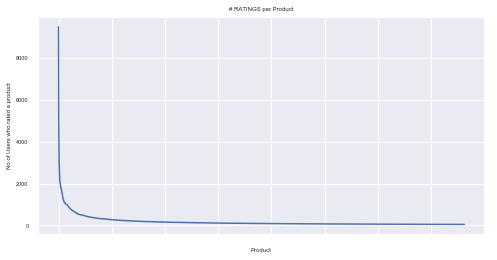

In [43]:

no_of_ratings_per_movie = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of Users who rated a product')
ax.set_xticklabels([])

plt.show()

In [44]:
#Average rating of the product 

new_df.groupby('productId')['Rating'].mean().head()

productId
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
1400532655    3.727273
Name: Rating, dtype: float64

In [45]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: Rating, dtype: float64

In [46]:
#Total no of rating for product

new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
B0002L5R78    9487
B0001FTVEK    5345
B000I68BD4    4903
B000BQ7GW8    4275
B00007E7JU    3523
Name: Rating, dtype: int64

In [47]:

ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())



In [48]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())



In [49]:
ratings_mean_count.head()

,Rating,rating_counts
productId,,
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171
1400532655,3.727273,484


In [50]:
ratings_mean_count['rating_counts'].max()

9487

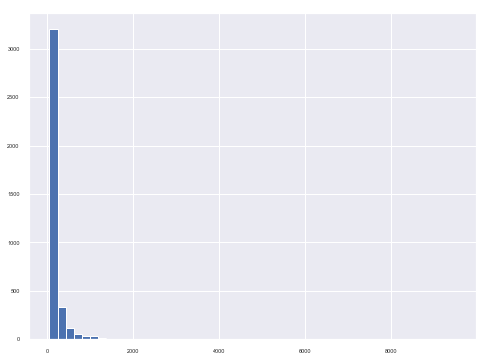

In [51]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

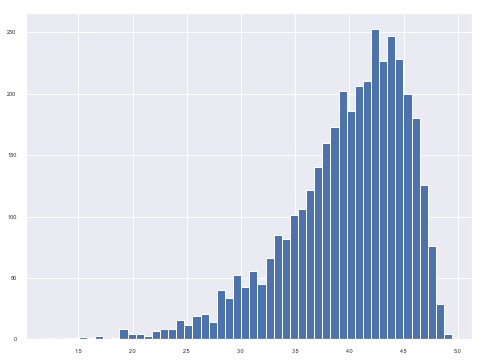

In [52]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

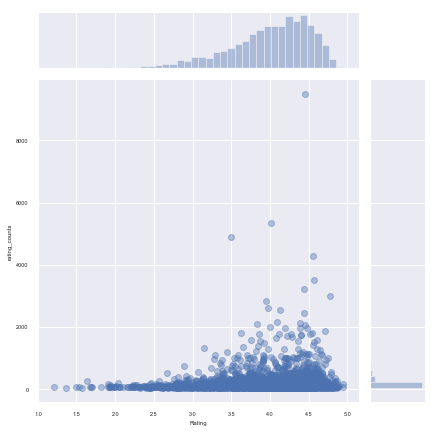

In [53]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

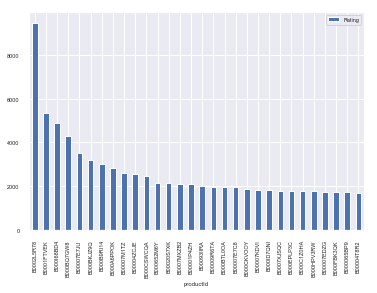

In [54]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")


# Collaberative filtering (Item-Item recommedation)

In [55]:
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise import accuracy
import os
from surprise.model_selection import train_test_split

In [56]:
reader= Reader()
data = Dataset.load_from_df(df_prc[['userId', 'productId', 'Rating']], reader)
trainset, testset = train_test_split(data, test_size=.30)

In [57]:
knnmeans_cv = cross_validate(KNNWithMeans(), data, cv=5, n_jobs=5, verbose=False)


In [58]:
svd_cv = cross_validate(SVD(), data, cv=5, n_jobs=5, verbose=False)


In [59]:
svdpp_cv = cross_validate(SVDpp(), data, cv=5, n_jobs=5, verbose=False)

In [60]:
coclus_cv = cross_validate(CoClustering(), data, cv=5, n_jobs=5, verbose=False)

In [61]:
## Dataframe to store Algorithm Results
algo_res = pd.DataFrame()

algo_res = algo_res.append({'Name' : "KNN Means" , "RMSE" : round(knnmeans_cv['test_rmse'].mean(),4), 
                            "MAE" : round(knnmeans_cv['test_mae'].mean(),4)} , ignore_index=True)
algo_res = algo_res.append({'Name' : "SVD" , "RMSE" : round(svd_cv['test_rmse'].mean(),4), 
                            "MAE" : round(svd_cv['test_mae'].mean(),4)} , ignore_index=True)
algo_res = algo_res.append({'Name' : "SVDPP" , "RMSE" : round(svdpp_cv['test_rmse'].mean(),4), 
                            "MAE" : round(svdpp_cv['test_mae'].mean(),4)} , ignore_index=True)
algo_res = algo_res.append({'Name' : "SlopeOne" , "RMSE" : round(coclus_cv['test_rmse'].mean(),4), 
                            "MAE" : round(coclus_cv['test_mae'].mean(),4)} , ignore_index=True)

In [62]:
## Print the RMSE And MAE for all the Algortihms
algo_res.head(4)

,MAE,Name,RMSE
0,0.8937,KNN Means,1.1607
1,0.7992,SVD,1.0589
2,0.7968,SVDPP,1.0568
3,0.9052,SlopeOne,1.1847


In [63]:

# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [64]:

# run the trained model against the testset
test_pred = algo.test(testset)

In [65]:
test_pred

[Prediction(uid='A5JLAU2ARJ0BO', iid='B0000APSKB', r_ui=5.0, est=4.2269295302013425, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AT6CZDCP4TRGA', iid='B000HZDF8W', r_ui=1.0, est=5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2B7BUH8834Y6M', iid='B0002I71LG', r_ui=4.0, est=4.2269295302013425, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2BGZ52M908MJY', iid='B00004ZCA5', r_ui=5.0, est=4.2269295302013425, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A12DLJESJKM1OQ', iid='B00008N6VM', r_ui=5.0, est=4.2269295302013425, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1VQHH85U7PX0', iid='B0002V9IKK', r_ui=5.0, est=4.2269295302013425, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1FR68QH6Z4YZM', iid='B000FGV59Y', r_ui=5.0, est=4.22692

In [66]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.2009


1.2009327267303636

In [67]:
param_grid = {'n_epochs': [5, 10, 15], 'lr_all': [0.002, 0.005, 0.008]}
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
grid_search.fit(data)

In [68]:
print('SVD   - RMSE:', round(grid_search.best_score['rmse'], 4))
print('RMSE =', grid_search.best_params['rmse'])

SVD   - RMSE: 1.0558
RMSE = {'n_epochs': 5, 'lr_all': 0.008}


In [69]:
## Training with Train Data and Test with the Data to find the RMSE
algo = SVD(n_epochs=100, lr_all=0.005)
algo.fit(trainset)
## test with test set
test_pred = algo.test(testset)
print("SVD : Test Set")
accuracy.rmse(test_pred, verbose=True)

SVD : Test Set
RMSE: 1.0304


1.030445602260645

In [70]:
from collections import defaultdict

In [71]:
ist_c = {}
#dist_c[2]
#dist_c = defaultdict(int)
#dist_c[2]
## method copied from https://surprise.readthedocs.io/en/stable/FAQ.html.
## method takes the input of Predictions (returned by surprise package predict method and returns)
## returns the top n predictions for each user.

def get_top_n(predictions, n=count):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    pred_df = pd.DataFrame()
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
        
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [72]:
## Wrapper function which internally calls the Top Recommendation method and arranges the same into a dataframe
def get_top_reco (count,test_pred):
    top_n = get_top_n(test_pred, n=count)
    pred_df = pd.DataFrame(columns=["UserId"])
    for uid, user_ratings in top_n.items():
        recommendations = {}
        reco = ""
        for (iid, _) in user_ratings:
            reco = reco + iid + ","
        dict_c={"UserId":uid,"Recommendation": reco }
        pred_df = pred_df.append(dict_c, ignore_index= True)
    return pred_df

In [73]:
## Function to use SVD algorithm and train the model generating the entire prediction data frame from the test data.
def generate_test(trainset,testset):
    algo = SVD(n_epochs=100, lr_all=0.005)
    algo.fit(trainset)
        ## test with test set
    test_pred = algo.test(testset)
    print("SVD : Test Set")
    accuracy.rmse(test_pred, verbose=True)
    return test_pred

In [74]:
## Function that takes as input USerid and 
## a) creates a train and test data set and calls function to trains the model using SVD model 
##  ,test the data (using test set) and return the all the recommendations for the Test data set 
## b) Filter  out the recommendation based on the User ID from the Test Data Set.
def find_reco(userid):
    trainset, testset = train_test_split(data, test_size=.30)
    test_pred = generate_test(trainset,testset)
    pred_out = get_top_reco (5,test_pred)
    reco = pred_out["Recommendation"][pred_out["UserId"] == userid ]
    return reco

In [75]:
## Main MEthod
userid = "ALQ4USPEQ9L5N"
reco = find_reco(userid) 
print("Recommendations:" , str(reco))

SVD : Test Set
RMSE: 1.0884
Recommendations: Series([], Name: Recommendation, dtype: object)


# Model-based collaborative filtering system

In [76]:

new_df1=new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

productId,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,3744295508,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userId,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
ratings_matrix.shape

(9832, 76)

In [78]:
X = ratings_matrix.T
X.head()

userId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productId,,,,,,,,,,,,,,,,,,,,,
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400532655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0


In [79]:

X.shape

(76, 9832)

In [80]:
X1 = X

In [81]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [82]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape


(76, 76)

In [92]:
val=
i = X.index[15]
i

'9625993428'

In [ ]:
#i = "9625993428"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

In [ ]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

In [ ]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:24]